# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planned. Space X performs a controlled landing in the oceans.


## Objectives


* Perform exploratory  Data Analysis and determine Training Labels
*   Create a column for the class
*   Standardize the data
*   Split into training data and test data
* Find best Hyperparameter for SVM, Classification Trees and Logistic Regression
*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

This function is to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load the dataframe


Load the data


In [3]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [4]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## TASK  1


Create the outcome variable from the column <code>Class</code> in <code>data</code>, then assign it to the variable <code>Y</code>, make sure the output is a Pandas series (only one bracket df\['name of  column']).


In [5]:
Y = data['Class']
type(Y)

pandas.core.series.Series

/tmp/ipython-input-6-329313045.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=df.index, y=df.values, palette='hls', alpha=0.9)
/tmp/ipython-input-6-329313045.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Unsuccessful', 'Successful'], minor=False, fontsize=12)


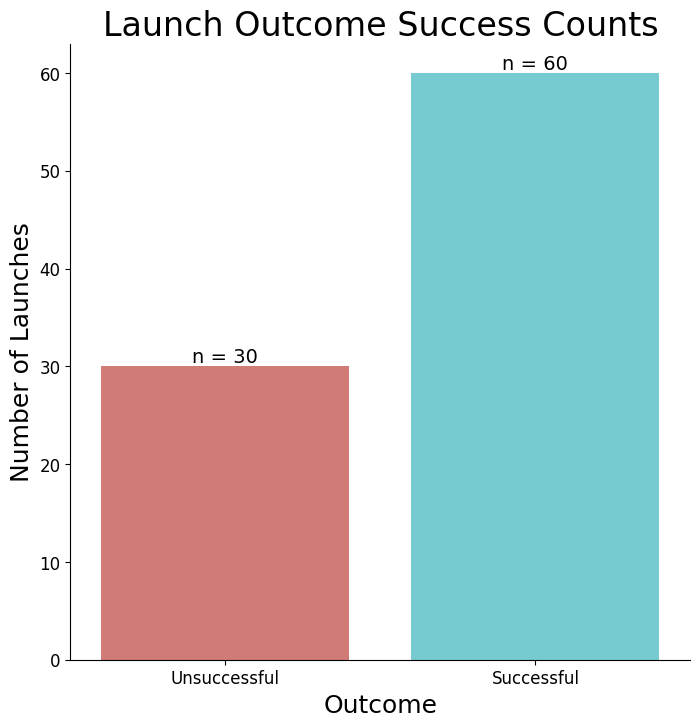

In [6]:
df=Y.value_counts()
plt.figure(figsize=(8,8))
ax=sns.barplot(x=df.index, y=df.values, palette='hls', alpha=0.9)
sns.despine(top=True, right=True, left=False, bottom=False)
for p in ax.patches:
    ax.annotate('n = {:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                ha='center', va='bottom', color='black', fontsize=14)
ax.set_xticklabels(['Unsuccessful', 'Successful'], minor=False, fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Launch Outcome Success Counts', fontsize=24)
plt.ylabel('Number of Launches',fontsize=18)
plt.xlabel('Outcome',fontsize=18)
plt.show()

## TASK  2


Use the function <code>train_test_split</code> to split the data sets `X` and `Y` into training and test data. Set the parameter <code>test_size</code> to 0.2 and random_state to 2.


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [8]:
X_train.shape

(72, 83)

In [9]:
X_test.shape

(18, 83)

After splitting the data, there are 72 records in our training set and 18 in our test set.

## TASK  3


Use the function using <code>fit_transform()</code> to standardize the training data so that we can learn the scaling parameters of our training set. Then, use these learned parameters to scale our test data.

In [10]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [11]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}
lr=LogisticRegression(random_state=1)
logreg_cv = GridSearchCV(lr, parameters, cv=10, refit=True)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [12]:
print("Tuned hyperparameters:",logreg_cv.best_params_)
print("Cross-validation accuracy:",logreg_cv.best_score_)

Tuned hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-validation accuracy: 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [13]:
glm_acc=logreg_cv.score(X_test, Y_test)
print("Test set accuracy: {:.1%}".format(glm_acc))
glm_probs = logreg_cv.predict_proba(X_test)[:,1]
glm_auc=roc_auc_score(Y_test, glm_probs)
print("Test set AUC: {:.3}".format(glm_auc))

Test set accuracy: 83.3%
Test set AUC: 0.889


Lets look at the confusion matrix:


              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18

Confusion matrix, without normalization
[[12  0]
 [ 3  3]]


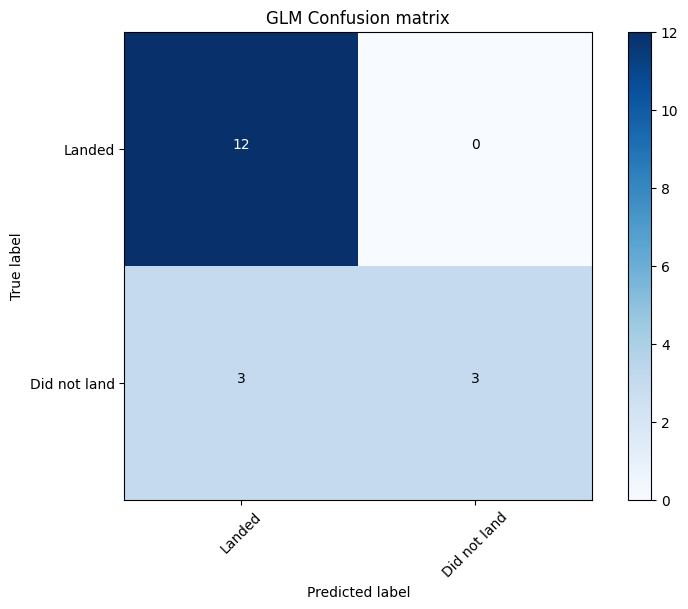

In [14]:
# Compute confusion matrix
glm_yhat = logreg_cv.predict(X_test)
glm_f1 = f1_score(Y_test, glm_yhat)
glm_prec = precision_score(Y_test, glm_yhat)
glm_rec = recall_score(Y_test, glm_yhat)
cnf_matrix = confusion_matrix(Y_test, glm_yhat, labels=[1,0])
np.set_printoptions(precision=2)
print(classification_report(Y_test, glm_yhat))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Landed', 'Did not land'], normalize= False, title='GLM Confusion matrix')

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [15]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC(probability=True, random_state=1)

In [16]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(probability=True, random_state=1),
             param_grid={'C': array([1.00e-03, 3.16e-02, 1.00e+00, 3.16e+01, 1.00e+03]),
                         'gamma': array([1.00e-03, 3.16e-02, 1.00e+00, 3.16e+01, 1.00e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [17]:
print("Tuned hyperparameters:",svm_cv.best_params_)
print("Cross-validation accuracy:",svm_cv.best_score_)

Tuned hyperparameters: {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
Cross-validation accuracy: 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [18]:
svm_acc=svm_cv.score(X_test, Y_test)
print("Test set accuracy: {:.1%}".format(svm_acc))
svm_probs = svm_cv.predict_proba(X_test)[:,1]
svm_auc=roc_auc_score(Y_test, svm_probs)
print("Test set AUC: {:.3}".format(svm_auc))

Test set accuracy: 83.3%
Test set AUC: 0.958


We can plot the confusion matrix


              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18

Confusion matrix, without normalization
[[12  0]
 [ 3  3]]


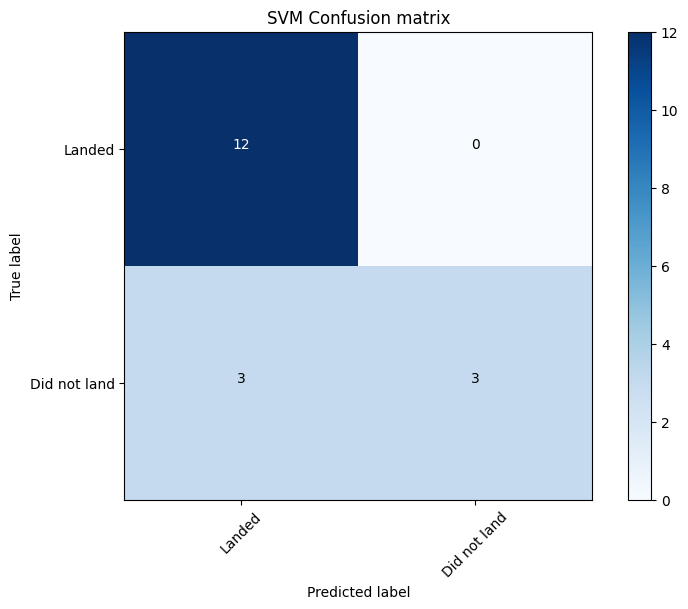

In [19]:
# Compute confusion matrix
svm_yhat = svm_cv.predict(X_test)
svm_f1 = f1_score(Y_test, svm_yhat)
svm_prec = precision_score(Y_test, svm_yhat)
svm_rec = recall_score(Y_test, svm_yhat)
cnf_matrix = confusion_matrix(Y_test, svm_yhat, labels=[1,0])
np.set_printoptions(precision=2)
print(classification_report(Y_test, svm_yhat))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Landed', 'Did not land'], normalize=False, title='SVM Confusion matrix')

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [20]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier(random_state=1)

In [21]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/u

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [22]:
print("Tuned hyperparameters:",tree_cv.best_params_)
print("Cross-validation Accuracy:",tree_cv.best_score_)

Tuned hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
Cross-validation Accuracy: 0.8357142857142857


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [23]:
tree_acc=tree_cv.score(X_test, Y_test)
print("Test set accuracy: {:.1%}".format(tree_acc))
tree_probs = tree_cv.predict_proba(X_test)[:,1]
tree_auc=roc_auc_score(Y_test, tree_probs)
print("Test set AUC: {:.3}".format(tree_auc))

Test set accuracy: 77.8%
Test set AUC: 0.792


We can plot the confusion matrix


              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.90      0.75      0.82        12

    accuracy                           0.78        18
   macro avg       0.76      0.79      0.77        18
weighted avg       0.81      0.78      0.78        18

Confusion matrix, without normalization
[[9 3]
 [1 5]]


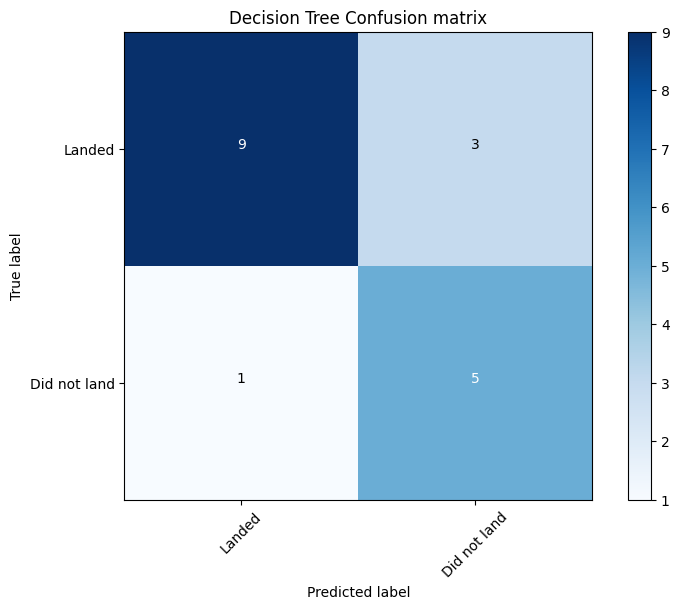

In [24]:
# Compute confusion matrix
tree_yhat = tree_cv.predict(X_test)
tree_f1 = f1_score(Y_test, tree_yhat)
tree_prec = precision_score(Y_test, tree_yhat)
tree_rec = recall_score(Y_test, tree_yhat)
cnf_matrix = confusion_matrix(Y_test, tree_yhat, labels=[1,0])
np.set_printoptions(precision=2)
print(classification_report(Y_test, tree_yhat))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Landed', 'Did not land'], normalize=False, title='Decision Tree Confusion matrix')

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [25]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [26]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [27]:
print("Tuned hyperparameters:",knn_cv.best_params_)
print("Cross-validation accuracy:",knn_cv.best_score_)

Tuned hyperparameters: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Cross-validation accuracy: 0.8482142857142858


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>accuracy_score</code>:


In [28]:
knn_acc = knn_cv.score(X_test, Y_test)
print("Test set accuracy: {:.1%}".format(knn_acc))
knn_probs = knn_cv.predict_proba(X_test)[:,1]
knn_auc=roc_auc_score(Y_test, knn_probs)
print("Test set AUC: {:.3}".format(knn_auc))

Test set accuracy: 83.3%
Test set AUC: 0.847


We can plot the confusion matrix


              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18

Confusion matrix, without normalization
[[12  0]
 [ 3  3]]


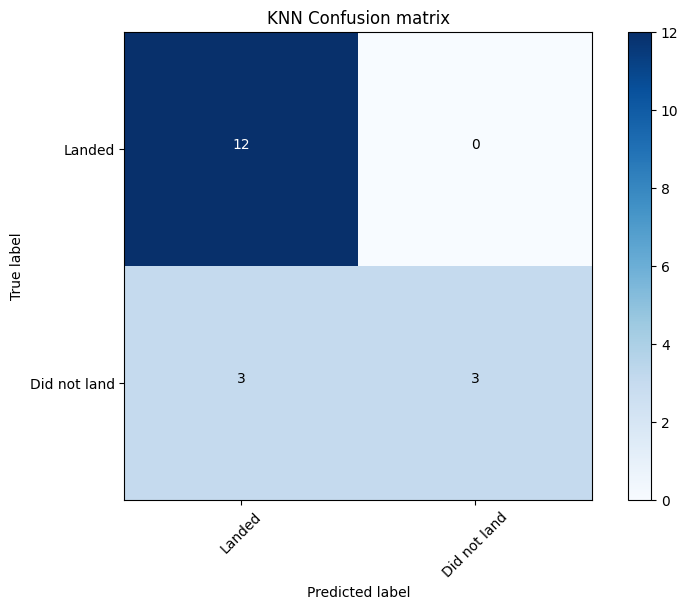

In [29]:
# Compute confusion matrix
knn_yhat = knn_cv.predict(X_test)
knn_f1 = f1_score(Y_test, knn_yhat)
knn_prec = precision_score(Y_test, knn_yhat)
knn_rec = recall_score(Y_test, knn_yhat)
cnf_matrix = confusion_matrix(Y_test, knn_yhat, labels=[1,0])
np.set_printoptions(precision=2)
print(classification_report(Y_test, knn_yhat))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Landed', 'Did not land'], normalize=False, title='KNN Confusion matrix')

## TASK  12


Find the method performs best:


In [30]:
data = {'AUC': [glm_auc, svm_auc, tree_auc, knn_auc], 'F1-Score': [glm_f1, svm_f1, tree_f1, knn_f1],
        'Precision': [glm_prec, svm_prec, tree_prec, knn_prec], 'Recall': [glm_rec, svm_rec, tree_rec, knn_rec],
        'Accuracy': [glm_acc, svm_acc, tree_acc, knn_acc]}
res = pd.DataFrame(data, index=['Logistic Regression', 'SVM', 'Decision Tree', 'KNN']).sort_values(by=['AUC'], ascending=False)
res.round(3)

,AUC,F1-Score,Precision,Recall,Accuracy
SVM,0.958,0.889,0.8,1.00,0.833
Logistic Regression,0.889,0.889,0.8,1.00,0.833
KNN,0.847,0.889,0.8,1.00,0.833
Decision Tree,0.792,0.818,0.9,0.75,0.778


/tmp/ipython-input-31-3578625047.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=res.index, y='Accuracy', data=res, palette='Blues_d')


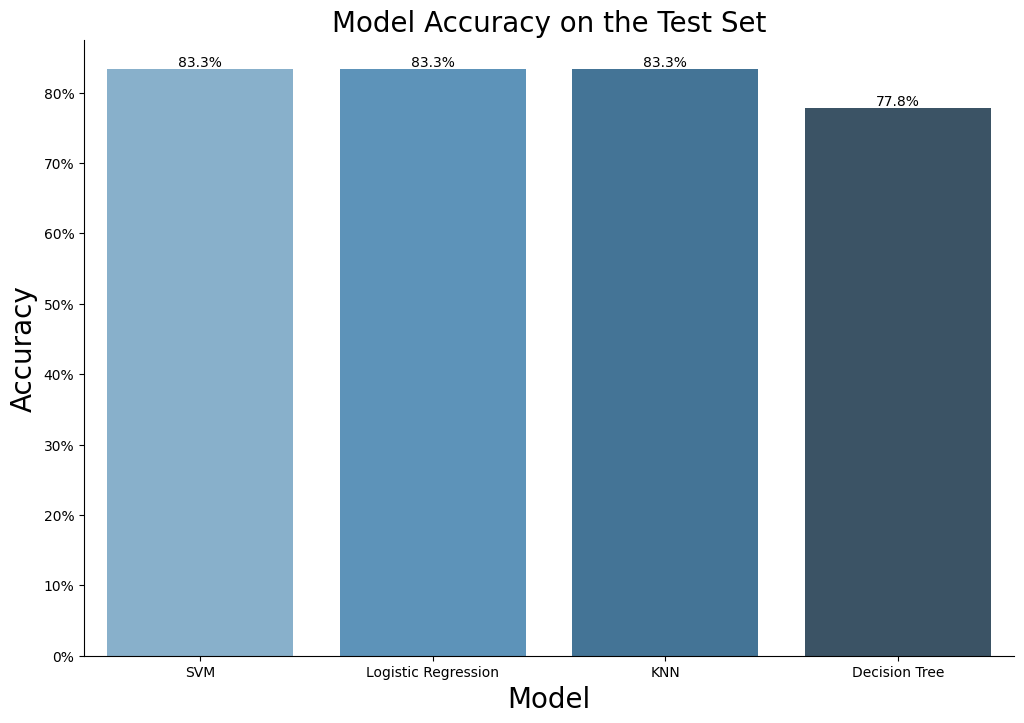

In [31]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=res.index, y='Accuracy', data=res, palette='Blues_d')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+0.4, p.get_height()),
                ha='center', va='bottom',color= 'black')
plt.title('Model Accuracy on the Test Set', fontsize=20)
plt.show()

/tmp/ipython-input-32-1429141227.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=res.index, y='AUC', data=res, palette='Blues_d')


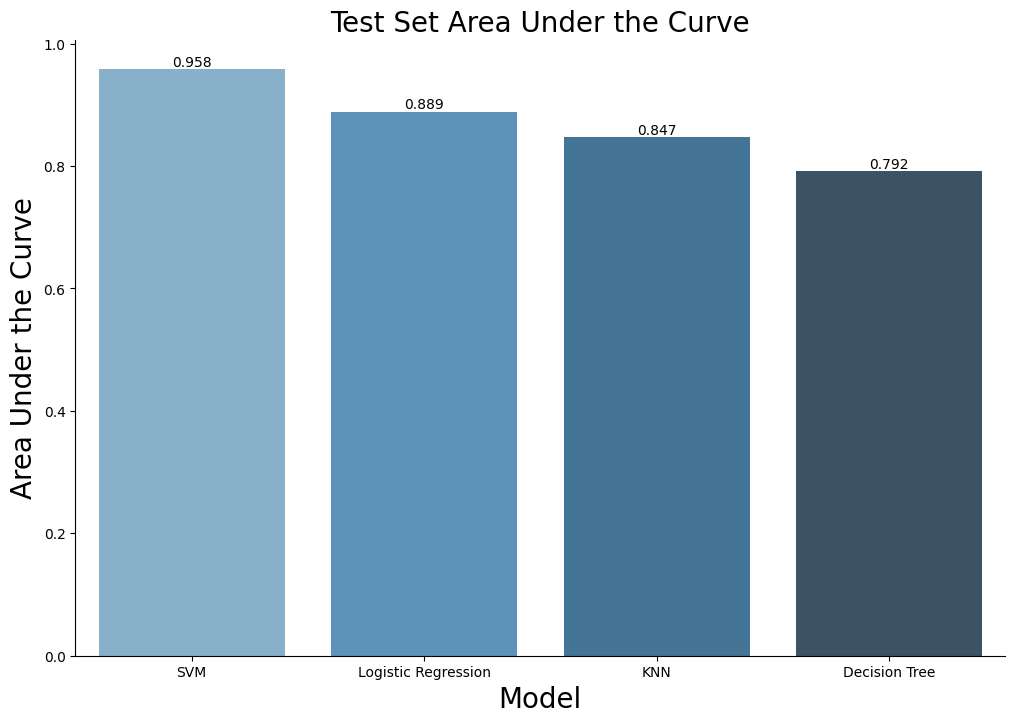

In [32]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=res.index, y='AUC', data=res, palette='Blues_d')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Area Under the Curve', fontsize=20)
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                ha='center', va='bottom',color='black')
plt.title('Test Set Area Under the Curve', fontsize=20)
plt.show()

The SVM, KNN, and Logistic Regression model achieved the highest accuracy at 83.3%, while the SVM performs the best in terms of Area Under the Curve at 0.958.